# Tutorial: Data Access and  Visualisation of Lake Water Level (LWL) timeseries 


The Copernicus Climate Change Service (C3S) is a European program with the objective of providing information on the current and past state of the climate. All this information is freely available after registration through the Climate Data Store (CDS) (https://cds.climate.copernicus.eu).

One of the datasets available from CDS provides lake water level information derived from satellite radar altimetry for selected lakes all around the world. This technique, originally conceived to study open ocean processes, have acquired numerous useful measurements over lakes. The Lake Water Level is defined as the height, in meters above the geoid (the shape that the surface would take under the influence of the gravity and rotation of Earth) of the reflecting surface. For each of the key lakes monitored within the C3S Lakes production system, the Level-3 Water Level is provided in separate file along with the corresponding uncertainty. 


One of the characteristics of the lake water level product is its irregular time step. A water level is estimated each time the lake is observed by a mission/track and, depending on the size and location of the lake, it may be monitored by multiple missions/tracks, with different repetitivities. An overview of the product characteristics is provided in the Product User Specification Guide (PUGS).

<b>Objective:</b>

The objective of this tutorial is to explain how to access the water level data for a specified lake and how to visualise its timeseries.

It is written in python and depends on the follow python libraries:


* cartopy
* cdsapi
* h5netcdf
* ipympl
* matplotlib
* netcdf4
* numpy
* xarray

<u>How to run this code in trough Binder:</u>

To run this tutorial via Binder (https://mybinder.org/), the jupyter notebook file must be included in a GitHub repository. The list of the packages that should be installed to run the code (list of python libraries indicated above) must be included in a configuration file : 'requirements.txt'. This file must also be available in the GitHub repository. Further information on Binder's configuration files is available at the following address: https://mybinder.readthedocs.io/en/latest/using/config_files.html


<font color='red'>Before continuing with this tutorial, please verify that the C3S API is installed. All the information about this api is available at: </font>

https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key

If the access to the api is not configured, you need to run the following code. It generates the '.cdsapi' file containing two variables : <b>URL</b> and <b>KEY</b>. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [1]:
%%bash

echo "url: https://cds.climate.copernicus.eu/api/v2
key: ########################################" >> .cdsapi



The tutorial consists of four main steps:

1. Download and decompress data 
2. Visualise the location of the lake in a map
3. Visualise and save water level timeseries
4. Visualise and save the yearly water level anomalies

## Import libraries


The lake water level data is downloaded in a zip file containing a NetCDF file. Some libraries are needed to download data from the CDS, but also to manage zip files (zipfile library) and NetCDF files (xarray library). Other libraries are used to plot and visualise the data (matplotlib and cartopy libraries).

Additional libraries: os and glob are used for file management 

In [2]:
import cdsapi
import os
import glob
import zipfile
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs, feature

Current version of the Lake Water Level dataset in CDS (v4.0) contains timeseries from 229 lakes. 

In [3]:
available_lakes =  [
            'achit', 'alakol', 'albert',
            'amadjuak', 'american_falls', 'aqqikol_hu',
            'argentino', 'athabasca', 'ayakkum',
            'aydarkul', 'aylmer', 'azhibeksorkoli',
            'bagre', 'baikal', 'bairab',
            'baker', 'balbina', 'balkhash',
            'bangweulu', 'bankim', 'baunt',
            'beas', 'beysehir', 'bienville',
            'big_trout', 'birch', 'biylikol',
            'bluenose', 'bodensee', 'bogoria',
            'bosten', 'bratskoye', 'bugunskoye',
            'cahora_bassa', 'caribou', 'caspian',
            'cayuga', 'cedar', 'cerros_colorados',
            'chagbo_co', 'chapala', 'chardarya',
            'chatyrkol', 'chishi', 'chlya',
            'chocon', 'chukochye', 'cienagachilloa',
            'claire', 'cochrane', 'corangamite',
            'cuodarima', 'dagze_co', 'dalai',
            'danau_towuti', 'danausingkarak', 'dangqiong',
            'des_bois', 'dogaicoring_q', 'dorgon',
            'dorsoidong_co', 'dubawnt', 'edouard',
            'egridir', 'erie', 'faber',
            'fitri', 'fontana', 'fort_peck',
            'garkung', 'george', 'gods',
            'grande_trois', 'greatslave', 'guri',
            'gyaring_co', 'gyeze_caka', 'habbaniyah',
            'hala', 'hamrin', 'har',
            'hawizeh_marshes', 'heishi_beihu', 'hendrik_verwoerd',
            'hinojo', 'hoh_xil_hu', 'hongze',
            'hottah', 'hovsgol', 'hulun',
            'huron', 'hyargas', 'iliamna',
            'illmen', 'inarinjarvi', 'issykkul',
            'iznik', 'jayakwadi', 'kabele',
            'kabwe', 'kainji', 'kairakum',
            'kamilukuak', 'kamyshlybas', 'kapchagayskoye',
            'kara_bogaz_gol', 'karasor', 'kariba',
            'kasba', 'khanka', 'kinkony',
            'kisale', 'kivu', 'kokonor',
            'kossou', 'krasnoyarskoye', 'kremenchutska',
            'kubenskoye', 'kulundinskoye', 'kumskoye',
            'kuybyshevskoye', 'kyoga', 'ladoga',
            'lagdo', 'lagoa_dos_patos', 'langa_co',
            'langano', 'lano', 'leman',
            'lixiodain_co', 'lumajangdong_co', 'luotuo',
            'mai_ndombe', 'malawi', 'mangbeto',
            'manitoba', 'memar', 'michigan',
            'migriggyangzham', 'mingacevir', 'mono',
            'mossoul', 'mullet', 'mweru',
            'naivasha', 'namco', 'namngum',
            'nasser', 'nezahualcoyoti', 'ngangze',
            'ngoring_co', 'nicaragua', 'nipissing',
            'novosibirskoye', 'nueltin', 'oahe',
            'old_wives', 'onega', 'ontario',
            'opinac', 'peipus', 'prespa',
            'pukaki', 'pyaozero', 'ranco',
            'roseires', 'rukwa', 'rybinskoye',
            'saint_jean', 'sakakawea', 'saksak',
            'san_martin', 'saratovskoye', 'sarykamish',
            'sasykkol', 'saysan', 'segozerskoye',
            'serbug', 'sevan', 'shiroro',
            'sobradino', 'soungari', 'srisailam',
            'superior', 'swan', 'tana',
            'tanganika', 'tangra_yumco', 'tchad',
            'tchany', 'telashi', 'teletskoye',
            'telmen', 'tengiz', 'tharthar',
            'titicaca', 'todos_los_santos', 'toktogul',
            'tonle_sap', 'tres_marias', 'tsimlyanskoye',
            'tumba', 'turkana', 'ulan_ul',
            'ulungur', 'umbozero', 'uvs',
            'valencia', 'van', 'vanajanselka',
            'vanerm', 'vattern', 'victoria',
            'viedma', 'volta', 'walker',
            'williston', 'winnipeg', 'winnipegosis',
            'xiangyang', 'yamzho_yumco', 'yellowstone',
            'zeyskoye', 'zhari_namco', 'zhelin',
            'ziling', 'zimbambo', 'ziway',
            'zonag',
        ]

# Lake selection


To download and visualise the timeseries, two inputs are required:

- The name of the lake (lake_name). The name of the lake must exist in the list of available lakes.
- The name of the output directory (output_dir) where the different files will be saved.

In [4]:
# the name of the lake
lake_name = 'Zhari-Namco'

# the output directory name 
output_dir = 'output'


A test is performed to verify that the water level of the selected lake is available. 

In [5]:
if lake_name.lower().replace('-', '_') not in available_lakes :
    print (f'The lake "{lake_name}" is not still available')

The output directory must exist. If this is not the case, it will be created. 

In [6]:
if os.path.exists(output_dir) == False:
    os.mkdirs(output_dir)

## 1. Download and decompress data

Using the CDS api, this function retrieves the data for the specified lake into the defined output directory. The downloaded file is compressed (zip format) containing the data file in NetCDF format. To read the lake water level data, the file is extracted in the output directory. 

In [7]:
c = cdsapi.Client()

list_regions = [ 'northern_africa', 'northern_north_america', 'southeastern_asia',
                 'southern_africa', 'southern_america', 'southern_north_america',
                 'southwestern_asia']

c.retrieve(
    'satellite-lake-water-level',
    {
        'variable': 'all',
        'region': list_regions,
        'lake': lake_name.lower().replace('-', '_'),
        'version': 'version_4_0',
        'format': 'zip',
    },
    f'{output_dir}/{lake_name}.zip')

with zipfile.ZipFile(f'{output_dir}/{lake_name}.zip') as z:
    z.extractall(f'{output_dir}')
    
# recover the lake filename in netcdf format
nc_file = glob.glob(f'{output_dir}/*{lake_name.upper().replace("_", "-")}*.nc')[0]

# open the file with Xarray
xr_lake = xr.open_dataset(nc_file)


2024-09-09 16:20:09,153 INFO Welcome to the CDS.
As per our announcements on the Forum, this instance of CDS will be decommissioned on 26 September 2024 and will no longer be accessible from this date onwards.
Please update your cdsapi package to a version >=0.7.2, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
2024-09-09 16:20:09,155 WARNING MOVE TO CDS-Beta
2024-09-09 16:20:09,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-lake-water-level
2024-09-09 16:20:09,305 INFO Request is completed
2024-09-09 16:20:09,306 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data8/dataset-satellite-lake-water-level-e61df0a1-fce1-4816-8357-cb687bc9b202.zip to output/Zhari-Namco.zip (10K)
2024-09-09 16:20:09,527 INFO Download rate 45.5K/s


 # 2. Visualise lake location
 
It is always useful to check the location of the lake on a map. Many of the world's lakes have the same name but may be located in different countries, as in the case of Lake Victoria: the best known is in Uganda, but there is also a Lake Victoria in Canada (48.35N, 57.11W) and another in Australia (34.04S, 141.28E). Or the name of the lake may be different, depending on the language: Caribou Lake or Reindeer Lake refer to the same lake (Canada). In some cases, even with the same language, the name of the lake may differ from one country to another: Lake Buenos Aires in Argentina and Lake General Carrera in Chile.

A world map showing the location of the lake is displayed. To generate this figure, we use the cartopy library.  

Lake location (lat, lon): 30.9°, 85.6°


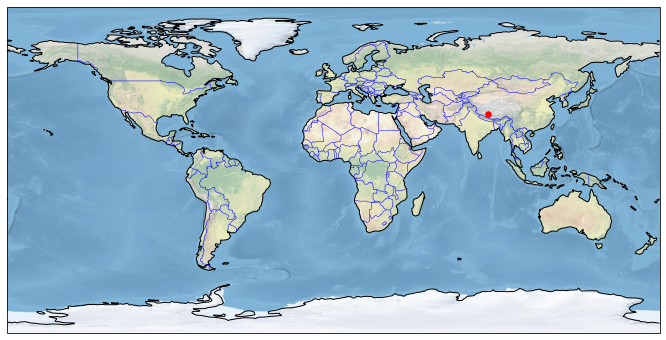

In [8]:
fig = plt.figure(figsize = (12,6))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()

# add lake location 
lat = float(xr_lake.lake_barycentre_latitude.split()[0])
if 'S' in xr_lake.lake_barycentre_latitude:
    lat = -lat
lon = float(xr_lake.lake_barycentre_longitude.split()[0])
if 'W' in xr_lake.lake_barycentre_longitude:
    lon = -lon
    
print (f"Lake location (lat, lon): {lat}°, {lon}°")
plt.scatter(x = [lon], y = [lat], s = 30, color = 'red', transform = crs.PlateCarree())

 # 3. Visualise lake water level time series

Once the data has been extracted, it can be read and visualised. Data in NetCDF format is read using the Xarray library, and Matplotlib is used to display time series.

The figure with the timeseries will be saved in the output directory in png format:
[lake_name]_timeseries.png file.

The change in observation time step caused by changes in coverage by multiple missions can be seen in the figure. In recent years, Lake Baikal has been monitored by multiple missions and trajectories. As a result, the temporal resolution increases (the time between observations is reduced) and the time series is noisier due to the effect of the inter-mission and inter-tracks bias. 

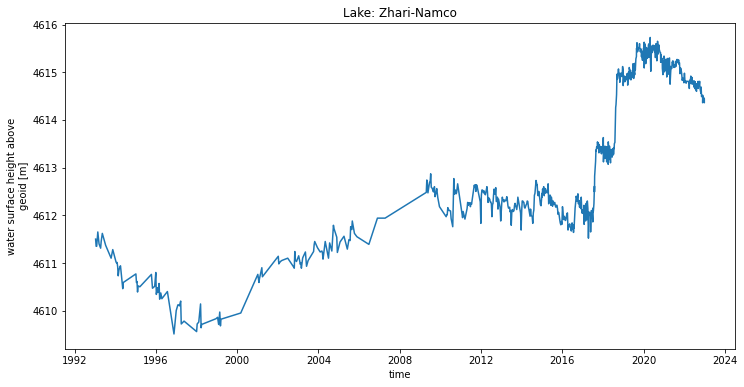

In [9]:
# plot and visualise the timeseries
fig = plt.figure(figsize = (12, 6))
xr_lake.water_surface_height_above_reference_datum.plot()
plt.title(f'Lake: {lake_name.title()}')

# save the figure
png_file = f'{output_dir}/{lake_name}_timeseries.png'
plt.savefig(png_file, dpi=300, bbox_inches="tight")

 # 4. Visualise lake water level yearly anomalies
 
Another way of analysing variations in water levels is to visualise anomalies in respect to average values over a reference period in form of a bar chart, using red and blue colours to easily identify the year when levels are higher or lower than the climatic normal.

The same code can be used for the visualisation of yearly anomalies compared to a particular year. 


The reference period can be adapted for each lake. The temporal coverage is not the same for all the lakes in the CDS, with the first available date ranging from 1992, as is the case for Lake Baikal, to 2019 for lakes monitored exclusively by the Sentinel-3B mission. In this example for Lake Baikal, we have chosen a reference period consisting of the first 10 years of data.

In [10]:
first_reference_year = 1992
last_reference_year  = 2002

The yearly anomaly is calculated using the following steps: i. applying xarray's groupby() function to group the data by year, and ii. calculating the mean value for each annual group. The average value of the water level in the selected lake is estimated as the average water level over the reference period.

In [11]:
yearly_mean = xr_lake.groupby('time.year').mean(keep_attrs = True)

ref = yearly_mean.where((yearly_mean.year >= first_reference_year ) & (yearly_mean.year <= last_reference_year ))
ref_lwl_mean = np.nanmean(ref.water_surface_height_above_reference_datum.values)

print (f'Mean LWL value during the reference period: {np.round(ref_lwl_mean,3)} (m)')

Mean LWL value during the reference period: 4610.444 (m)


The yearly anomaly is shown in red for the annual values above the average water level during the reference period and in blue for the annual values below.

The figure with the anomalies is saved in the output directory in png format :
[lake_name]_yearly-anomalies.png file.

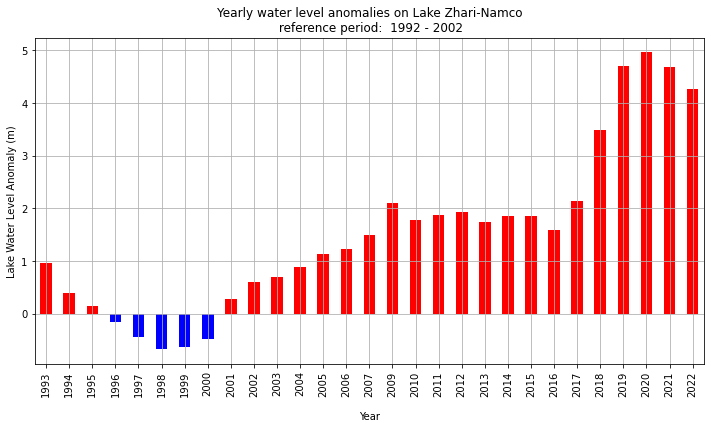

In [12]:
year_mean = yearly_mean.to_dataframe()
year_mean['lwl_yearly_anomaly'] = year_mean['water_surface_height_above_reference_datum'] - ref_lwl_mean
year_mean['positive_anomaly'] = year_mean['lwl_yearly_anomaly'] > 0

fig, ax = plt.subplots(figsize=(12, 6))
year_mean['lwl_yearly_anomaly'].plot(kind='bar', 
                                     color = year_mean.positive_anomaly.map ({True: 'red', False: 'blue'}),
                                     xlabel = '\nYear',
                                     ylabel = 'Lake Water Level Anomaly (m)',
                                     title = f'Yearly water level anomalies on Lake {lake_name.title().replace("_", "-")}\n reference period:  {first_reference_year} - {last_reference_year}')

ax.grid()

# save the figure
png_file = f'{output_dir}/{lake_name}_yearly-anomalies.png'
plt.savefig(png_file, dpi=300, bbox_inches='tight')